In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error
from numba import jit, cuda
from timeit import default_timer as timer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [ ]:
# @jit(target_backend='cuda')
data = pd.read_csv("E:\python projects\leetcodepractice\IoT dataset\IoT Network Intrusion Dataset.csv")

print("original dataset shape", data.shape)
# duplicate_rows = data[data.duplicated()]
print(data.info())
print(data.head()) # showing top 5 rows of 86 columns
print(data.describe())
print(data.isna().sum().any())
# print(data.duplicated().any())
# clean_data = data.drop_duplicates()
clean_data = data
# print("dataset shape after removing duplicates", clean_data.shape)
print(clean_data.shape)

original dataset shape (625783, 86)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625783 entries, 0 to 625782
Data columns (total 86 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow_ID            625783 non-null  object 
 1   Src_IP             625783 non-null  object 
 2   Src_Port           625783 non-null  int64  
 3   Dst_IP             625783 non-null  object 
 4   Dst_Port           625783 non-null  int64  
 5   Protocol           625783 non-null  int64  
 6   Timestamp          625783 non-null  object 
 7   Flow_Duration      625783 non-null  int64  
 8   Tot_Fwd_Pkts       625783 non-null  int64  
 9   Tot_Bwd_Pkts       625783 non-null  int64  
 10  TotLen_Fwd_Pkts    625783 non-null  int64  
 11  TotLen_Bwd_Pkts    625783 non-null  int64  
 12  Fwd_Pkt_Len_Max    625783 non-null  int64  
 13  Fwd_Pkt_Len_Min    625783 non-null  int64  
 14  Fwd_Pkt_Len_Mean   625783 non-null  float64
 15  Fwd_Pkt_Len_Std

False
(625783, 86)


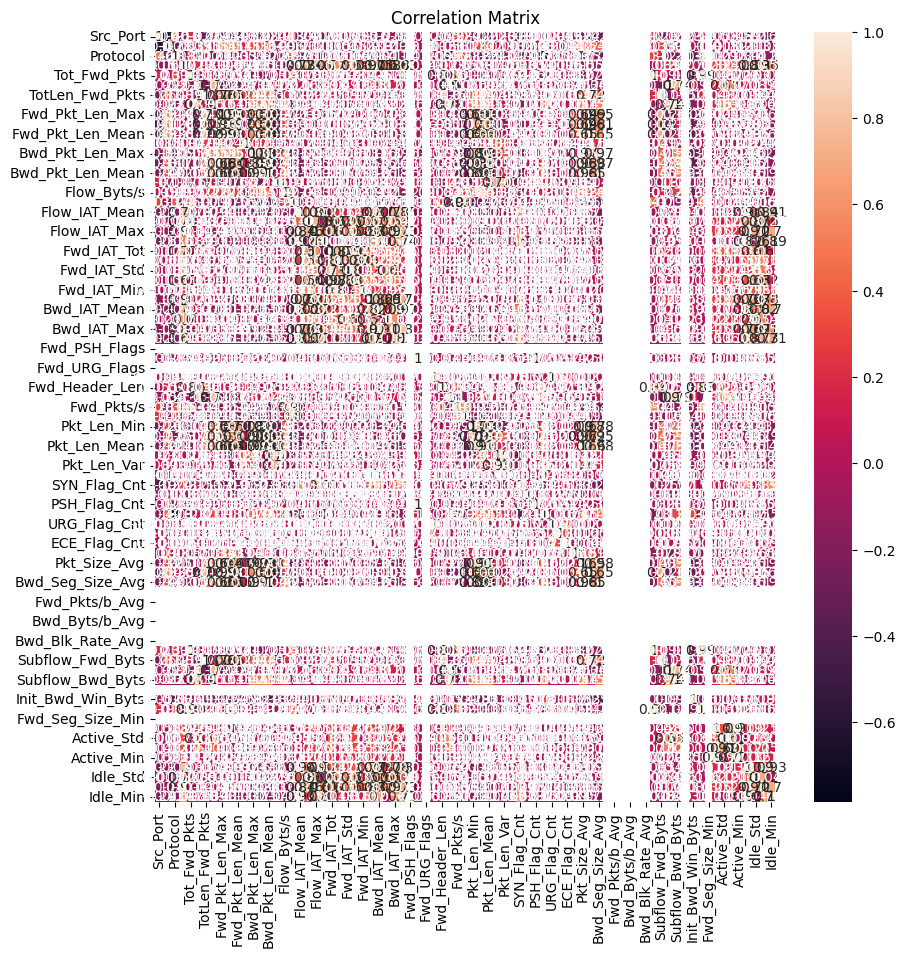

In [ ]:
plt.figure(figsize=(10,10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

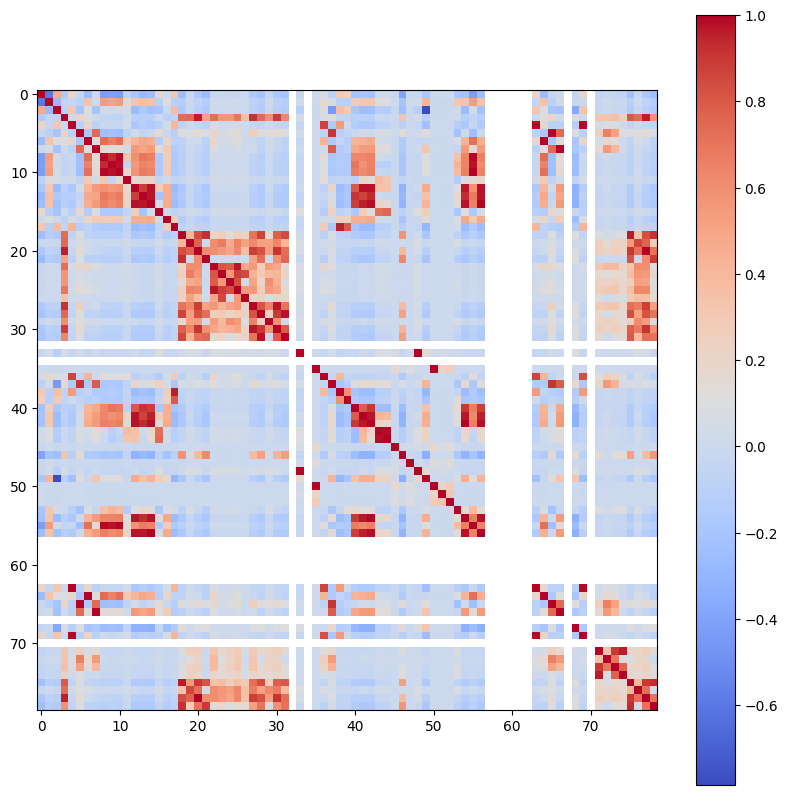

In [ ]:
corr_matrix = clean_data.corr()
plt.figure(figsize=(10,10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
# @jit(target_backend='cuda')
def detecting_zeros(clean_data = clean_data):
    num_zeros = {}
    for x in clean_data:
        column = clean_data[x]
        counts = column.value_counts()
        if 0 in counts.index:
            zeros = counts[0]
            num_zeros[x] = zeros
        else:
            zeros = 0
            num_zeros[x] = zeros
    return pd.DataFrame.from_dict(num_zeros, orient="index")

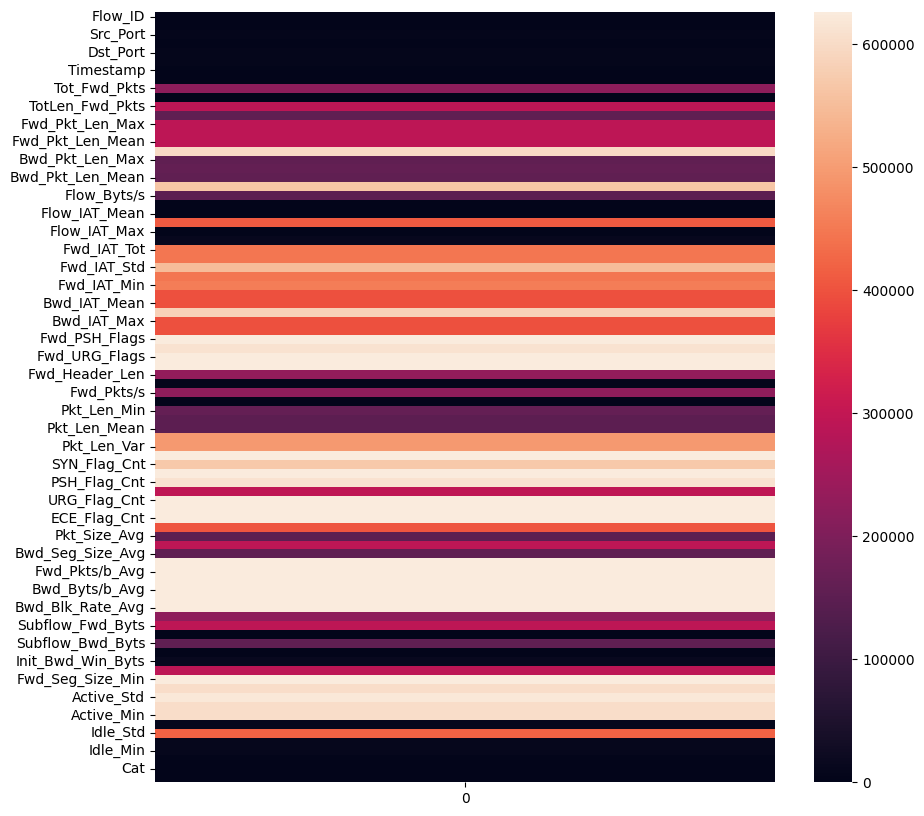

In [ ]:
# @jit(target_backend='cuda')
detected_zeros = detecting_zeros(clean_data)
plt.figure(figsize=(10,10))
sns.heatmap(detected_zeros)
plt.show()

In [ ]:
percentage_of_zeros = detected_zeros / clean_data.shape[0] * 100
print(f"percentage of zeros in every feature : {percentage_of_zeros}")

percentage of zeros in every feature :                  0
Flow_ID   0.000000
Src_IP    0.000000
Src_Port  1.009136
Dst_IP    0.000000
Dst_Port  1.009136
...            ...
Idle_Max  1.468560
Idle_Min  1.468560
Label     0.000000
Cat       0.000000
Sub_Cat   0.000000

[86 rows x 1 columns]


In [ ]:
detecting_unnecessory_features = (percentage_of_zeros[percentage_of_zeros.values >= 80].index).tolist()
print(f"unnecessory features :{detecting_unnecessory_features}")

clean_data.drop(columns= detecting_unnecessory_features, inplace=True)
print(f"shape of data after removing unnecessory features : {clean_data.shape}")

unnecessory features :['Fwd_Pkt_Len_Std', 'Bwd_Pkt_Len_Std', 'Fwd_IAT_Std', 'Bwd_IAT_Std', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Fwd_URG_Flags', 'Bwd_URG_Flags', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'URG_Flag_Cnt', 'CWE_Flag_Count', 'ECE_Flag_Cnt', 'Fwd_Byts/b_Avg', 'Fwd_Pkts/b_Avg', 'Fwd_Blk_Rate_Avg', 'Bwd_Byts/b_Avg', 'Bwd_Pkts/b_Avg', 'Bwd_Blk_Rate_Avg', 'Fwd_Seg_Size_Min', 'Active_Mean', 'Active_Std', 'Active_Max', 'Active_Min']
shape of data after removing unnecessory features : (625783, 60)


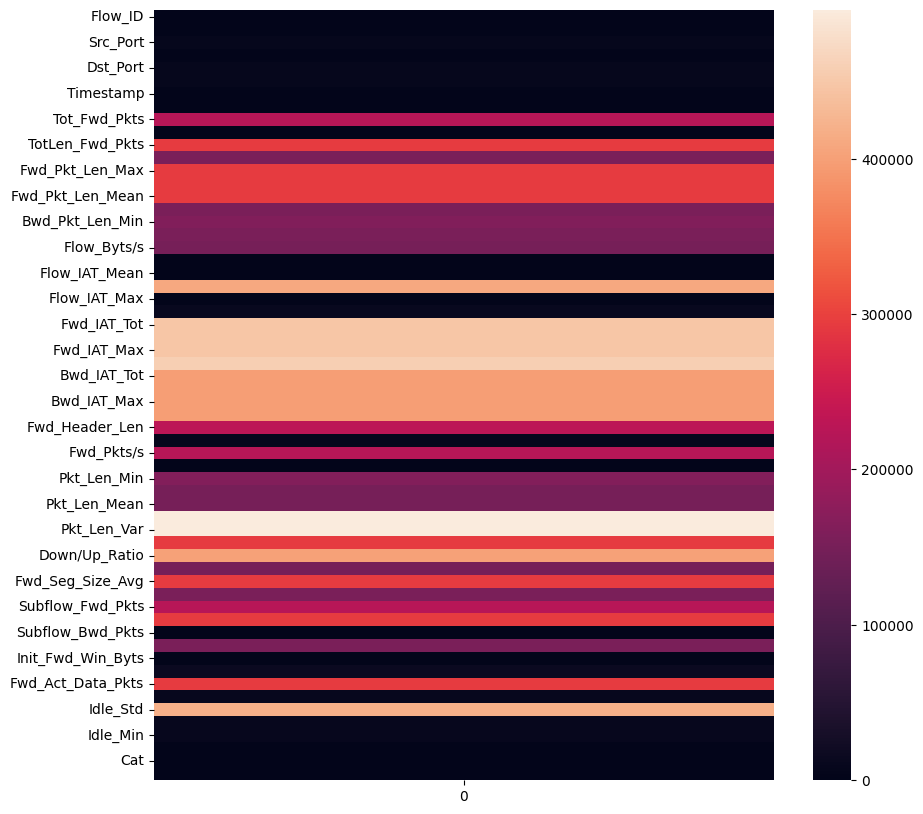

In [ ]:
detected_zeros = detecting_zeros(clean_data)

percentage_of_zeros = detected_zeros / clean_data.shape[0] * 100

plt.figure(figsize=(10,10))
sns.heatmap(detected_zeros)
plt.show()

In [ ]:
# @jit(target_backend='cuda')
order_label = {"Anomaly":1, "Normal":0}
clean_data['Label'] = clean_data['Label'].map(order_label)

le = LabelEncoder()
clean_data[['Cat']] = clean_data[['Cat']].apply(le.fit_transform)

detecting_unnecessory_features = ['Sub_Cat','Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp', 'Init_Bwd_Win_Byts', 'Init_Fwd_Win_Byts']
clean_data.drop(columns= detecting_unnecessory_features, axis=1, inplace=True)

# print(clean_data.info())
X = clean_data.drop(["Cat"], axis=1)
y = clean_data.Cat

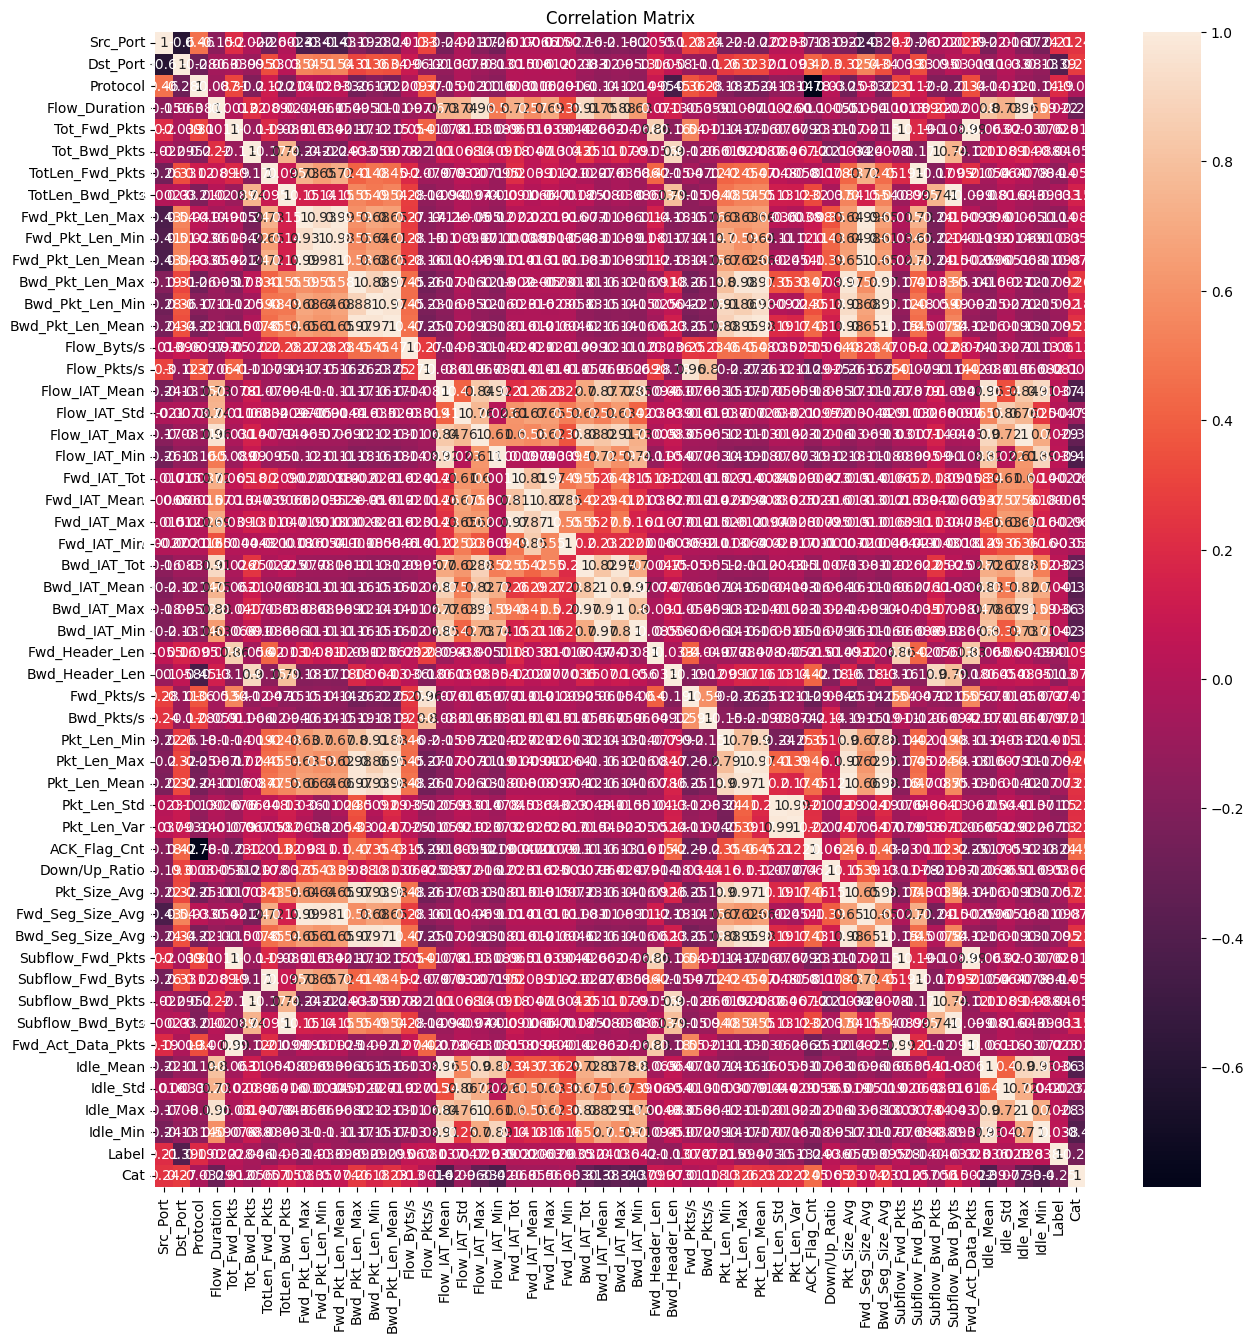

In [ ]:
plt.figure(figsize=(15,15))
corr_matrix = clean_data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.clip(X,-1, (2*32)-1), y, test_size=0.20, random_state=42)

In [ ]:
Cs = [0.001, 0.1, 1, 10, 100]
log_reg = LogisticRegression()
best_fit = GridSearchCV(estimator = log_reg, param_grid = dict(C=Cs) , cv = 5, scoring= 'accuracy')
best_fit.fit(X_train,y_train)
print("Best score is", best_fit.best_score_, 'for C =', float(best_fit.best_params_['C']))

C:\Users\Amazon\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Amazon\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Amazon\an

C:\Users\Amazon\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Amazon\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Amazon\an

Best score is 0.7791425121450593 for C = 0.001


C:\Users\Amazon\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
log_reg = LogisticRegression(C=best_fit.best_params_['C'])
# log_reg = LogisticRegression(C=0.1)
log_reg.fit(X_train,y_train)

C:\Users\Amazon\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=0.1)

In [ ]:
predicted = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print('Accuracy score: ', accuracy)
print("Report : ",classification_report(y_test, predicted))

Accuracy score:  0.7772158169339309
Report :                precision    recall  f1-score   support

           0       0.92      0.97      0.94     12079
           1       0.91      0.17      0.28      6967
           2       0.80      0.93      0.86     82954
           3       0.72      0.38      0.50      8013
           4       0.41      0.25      0.31     15144

    accuracy                           0.78    125157
   macro avg       0.75      0.54      0.58    125157
weighted avg       0.76      0.78      0.75    125157



In [ ]:
rfc=RandomForestClassifier(random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=10, criterion='entropy')

In [ ]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       random_state=42)

In [ ]:
pred=rfc1.predict(X_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))
print("Report : ",classification_report(y_test, pred))

Accuracy for Random Forest on CV data:  0.8422141789911871
Report :                precision    recall  f1-score   support

           0       1.00      0.99      0.99     12079
           1       0.92      0.17      0.29      6967
           2       0.83      0.96      0.90     82954
           3       1.00      1.00      1.00      8013
           4       0.53      0.28      0.36     15144

    accuracy                           0.84    125157
   macro avg       0.86      0.68      0.71    125157
weighted avg       0.83      0.84      0.81    125157



NameError: ignored

Accuracy for decision tree classifier :  0.8435884529031537
Report :                precision    recall  f1-score   support

           0       1.00      0.99      1.00     12079
           1       0.90      0.18      0.30      6967
           2       0.84      0.96      0.90     82954
           3       1.00      1.00      1.00      8013
           4       0.53      0.29      0.37     15144

    accuracy                           0.84    125157
   macro avg       0.85      0.68      0.71    125157
weighted avg       0.83      0.84      0.82    125157

